# Palmer Penguins: Multiclass Classification Notebook
---
This Jupyter notebook demonstrates a full machine-learning workflow for the Palmer Penguins dataset (UCI / Palmer penguins). It covers:
 - Data loading (UCI URL + seaborn fallback)
 - EDA with narrative and inline plots
 - Data cleaning and preprocessing (imputation, encoding, scaling)
 - Train/test split and stratification
 - Model training with cross-validation and GridSearchCV
 - Comparison of out-of-sample performance and training time
 - SHAP interpretability for the best model (per-class explanations)


### NOTE: run this notebook in a Python environment with the following packages installed:
`pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `shap (>=0.40)`, `joblib`

In [2]:
# Our machine learning will use scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# We will load our data into pandas dataframes
import pandas as pd

# We will use this to make plots
import matplotlib.pyplot as plt
import seaborn as sns

# We will time our models to compare them
import time

## 2. Load the Data

In this section, we load the Palmer Penguins dataset, which contains measurements of penguin species observed in the Palmer Archipelago, Antarctica.  
The dataset includes biological and physical attributes—such as bill length, flipper length, and body mass—for three species of penguins: **Adélie**, **Chinstrap**, and **Gentoo**.

We first attempt to load the dataset directly from [Allison Horst’s GitHub repository](https://github.com/allisonhorst/palmerpenguins), which provides the canonical version of the Palmer Penguins data in CSV format.  
If that online source is unavailable (e.g., due to a temporary network issue), the code automatically falls back to the version included with the **seaborn** library, ensuring the analysis continues smoothly without interruption.

In [3]:
df = pd.read_csv("../data/penguins.csv")

Let's quickly look at the data we just loaded:

In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


We notice a few things about the data.

- The data has both string and numerical columns.

- There is some missing data, denoted by NaN.

- There is a column we won't end up using: year.

We can also look at the dataframe's info() to get broad information about the data:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


## 3. Exploratory Data Analysis (EDA)

Before we build any models, we explore and visualize the data to understand its structure, distribution, and relationships between variables.

In this section, we:
- Examine the dataset's dimensions, data types, and missing values.
- Visualize numerical feature distributions (e.g., bill length, flipper length, body mass).
- Compare how these features differ across penguin species.
- Explore relationships and correlations between numeric predictors.
- Identify any potential data quality issues (e.g., missing values or outliers).

Through this exploratory analysis, we build an intuition for what distinguishes each penguin species and identify which variables may be most useful for classification.

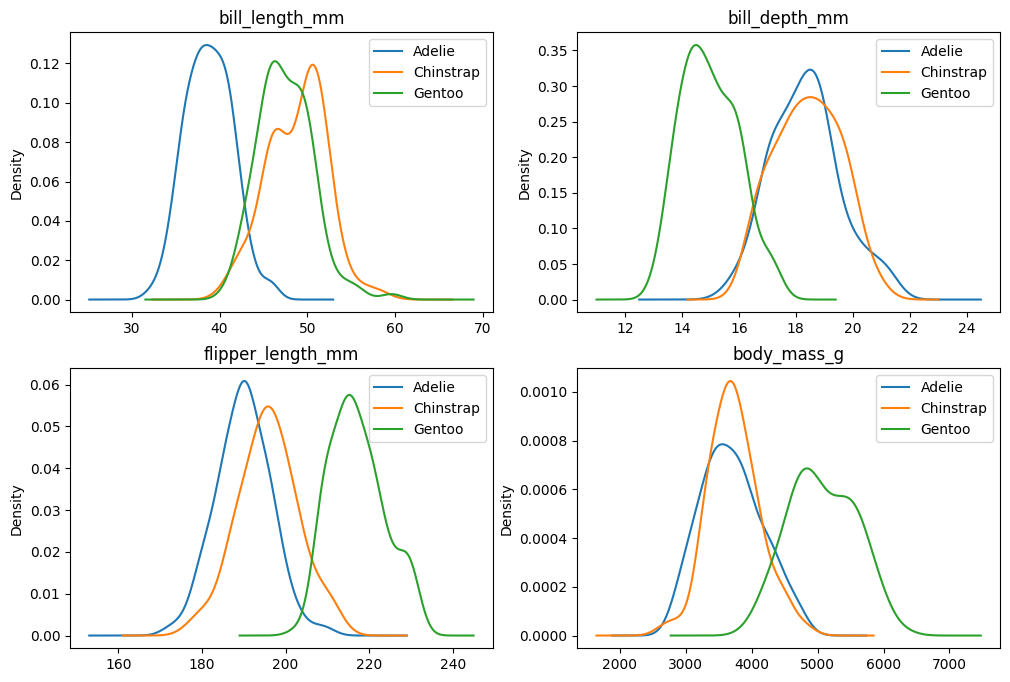

In [6]:
col_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(12, 8))
for i, col in enumerate(col_names, 1):
    plt.subplot(2, 2, i)
    df.groupby('species')[col].plot(kind='density', legend=True)
    plt.title(col)
plt.show()

Here's a bar graph of the species on each island:

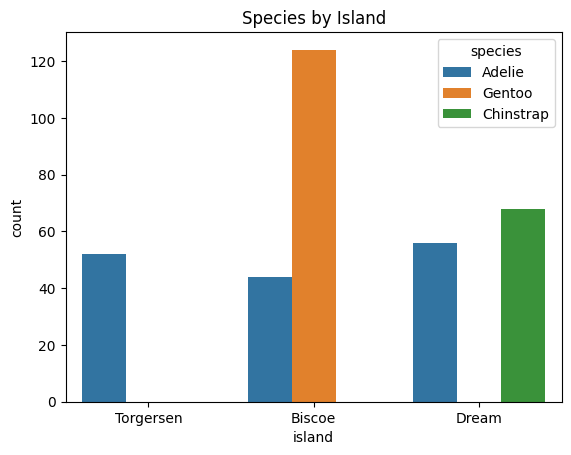

In [7]:
sns.countplot(x='island', hue='species', data=df)
plt.title('Species by Island')
plt.show()

Species by sex:

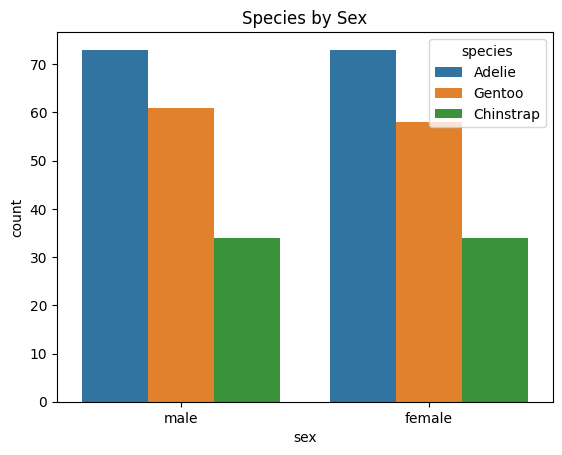

In [8]:
sns.countplot(x='sex', hue='species', data=df)
plt.title('Species by Sex')
plt.show()

Our exploratory analysis gives us a solid understanding of the data's structure and potential issues.  

Next, we'll clean and preprocess the dataset to ensure it's ready for modeling.

## 4. Data Cleaning and Preprocessing

Raw data typically requires cleaning and transformation before it can be used effectively for modeling.  
In this section, we prepare the data for training by performing the following steps:

1. **Handling Missing Values:**  
   Impute missing numeric values with the median and categorical values with the mode, preserving overall data structure.

2. **Encoding Categorical Variables:**  
   Convert string-based features such as `island` and `sex` into numerical form using one-hot encoding.

3. **Feature Scaling:**  
   Standardize numeric predictors (mean = 0, standard deviation = 1) to ensure models like logistic regression and SVM are not biased by variable scale differences.

4. **Train-Test Split:**  
   Split the dataset into a training and testing set (e.g., 70/30) using stratified sampling to maintain class balance across penguin species.

After preprocessing, the cleaned dataset will be ready for fitting a variety of classification models.

We drop the NaN data:

In [9]:
df = df.dropna()

It's good to be organized and reset_index on the dataframe now:

In [10]:
df = df.reset_index(drop=True)

Now we split the data into (x, y) pairs, where we map the x data to the y targets.

We will use the species as the y data, and the remaining columns as the x data.

In [11]:
TARGET = 'species'
y = df[TARGET]

X = df[['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']]

Here is the shape of our data, having 6 columns:

In [12]:
print(X.shape, y.shape)

(333, 6) (333,)


In [13]:
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,male
1,Torgersen,39.5,17.4,186.0,3800.0,female
2,Torgersen,40.3,18.0,195.0,3250.0,female
3,Torgersen,36.7,19.3,193.0,3450.0,female
4,Torgersen,39.3,20.6,190.0,3650.0,male


In [14]:
X = pd.get_dummies(X, dtype=float)

Now that our dataset is preprocessed and standardized, we can begin training classification models to predict penguin species.

## 5. Modeling and Baseline Comparison

Now that the data is clean and standardized, we train several classification algorithms to predict the penguin species.

We will compare a range of models representing different algorithmic families:
- **Logistic Regression** — a linear baseline model.
- **Random Forest** — an ensemble of decision trees with bootstrap aggregation.
- **Gradient Boosting (LightGBM)** — a powerful boosting-based ensemble method.
- **Support Vector Machine (SVM)** — a margin-based classifier.

Each model is trained and evaluated using cross-validation to estimate its out-of-sample accuracy.  

We also record training time to understand the trade-offs between model complexity, performance, and computational efficiency.

### Train-test split

We should probably do train-validation-test if we want to monitor training later.

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42  #, stratify=Y
)

The previous function also conveniently puts the data in a random order:

### Normalize the data before model input

In [16]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Define a model

Need to explain

![title](https://ars.els-cdn.com/content/image/1-s2.0-S0925231223004502-gr1.jpg)

In [17]:
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(8, 8),
    max_iter=1000,
    random_state=42)

### Train the model

Scikit-learn, and most machine learning programs, have a built-in fit function that will conveniently train the model for us.

In [18]:
mlp.fit(X_train, y_train)

,hidden_layer_sizes,"(8, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


Plot the training loss over time:

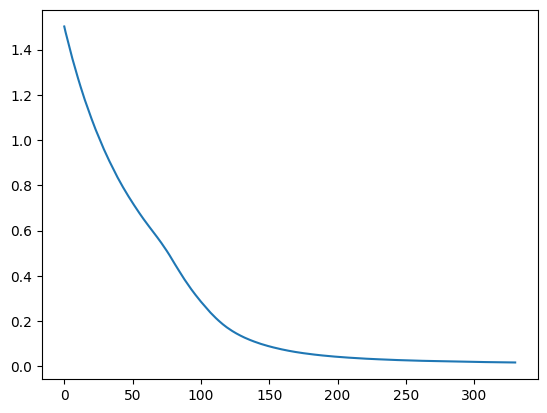

In [19]:
plt.plot(mlp.loss_curve_)
plt.show()

We can see that the model stopped training after the loss value levelled off near a stable minimum.

### Use the trained model to do predictions on the test data

In [20]:
y_pred = mlp.predict(X_test)

### Evaluate the model predictions

In [21]:
sklearn.metrics.accuracy_score(y_test, y_pred)

1.0

In [22]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        18

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



In [23]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[31,  0,  0],
       [ 0, 18,  0],
       [ 0,  0, 18]])

## Comparing different models

In [24]:
models = {}

- Logistic Regression — a linear baseline model

In [25]:
models['LogisticRegression'] = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=5000, n_jobs=-1)

- Random Forest — an ensemble of decision trees with bootstrap aggregation

In [26]:
models['RandomForest'] = RandomForestClassifier(random_state=42, n_jobs=-1)

- Support Vector Machine (SVM) — a margin-based classifier

In [27]:
models['SVM'] = SVC(kernel='rbf', probability=True)

- Gradient Boosting — a powerful boosting-based ensemble method

In [28]:
models['GradientBoosting'] = sklearn.ensemble.GradientBoostingClassifier()

In [29]:
print(f"Models: {models}\n")

Models: {'LogisticRegression': LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   solver='saga'), 'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42), 'SVM': SVC(probability=True), 'GradientBoosting': GradientBoostingClassifier()}




=== LogisticRegression ===
Accuracy: 1.0
Training time: 0.019502878189086914 seconds.


/home/adam/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


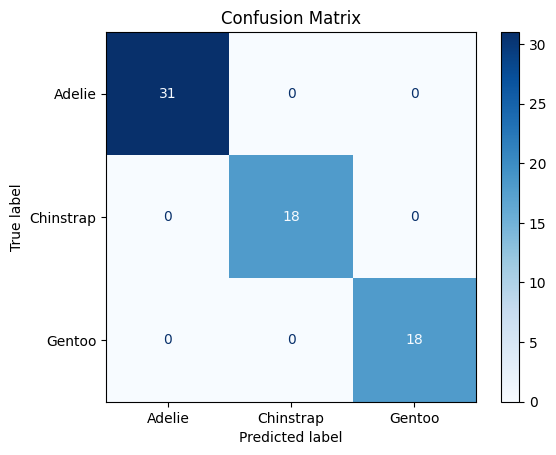

Classification Report:

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        18

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


=== RandomForest ===
Accuracy: 1.0
Training time: 0.08922696113586426 seconds.


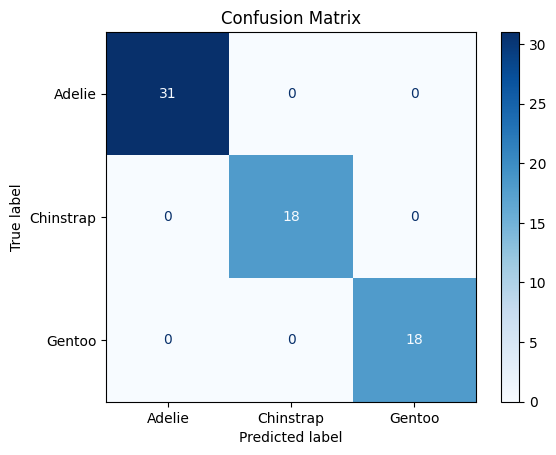

Classification Report:

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        18

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


=== SVM ===
Accuracy: 1.0
Training time: 0.003147125244140625 seconds.


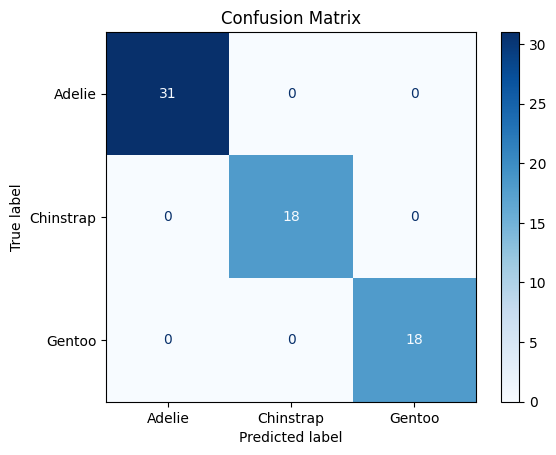

Classification Report:

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        18

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


=== GradientBoosting ===
Accuracy: 1.0
Training time: 0.2106170654296875 seconds.


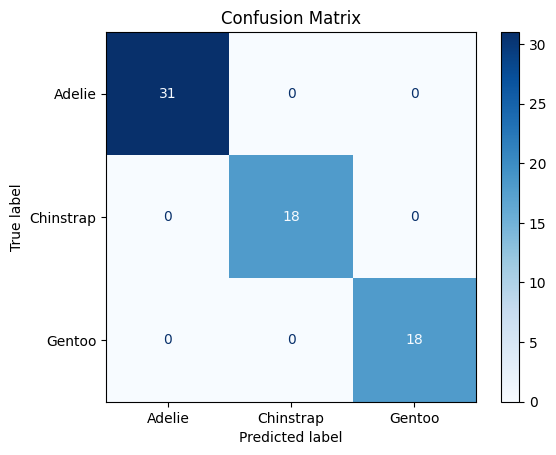

Classification Report:

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        18
      Gentoo       1.00      1.00      1.00        18

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


Models Comparison:
                model  accuracy  precision  recall   f1  train_time_s
0  LogisticRegression       1.0        1.0     1.0  1.0      0.019503
1        RandomForest       1.0        1.0     1.0  1.0      0.089227
2                 SVM       1.0        1.0     1.0  1.0      0.003147
3    GradientBoosting       1.0        1.0     1.0  1.0      0.210617


In [30]:
results = []
for name, estimator in models.items():
    print(f"\n=== {name} ===")
    #pipe = Pipeline([('preprocessor', preprocessor), ('classifier', estimator)])
    #grid = GridSearchCV(pipe, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    model = models[name]
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print('Accuracy:', acc)
    print(f'Training time: {elapsed} seconds.')

    # 1) Metrics results
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'train_time_s': elapsed,
    })

    # 2) Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # 3) Classification report
    report = classification_report(y_test, y_pred, target_names=model.classes_)
    print("Classification Report:\n")
    print(report)

results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
print("\nModels Comparison:")
print(results_df)

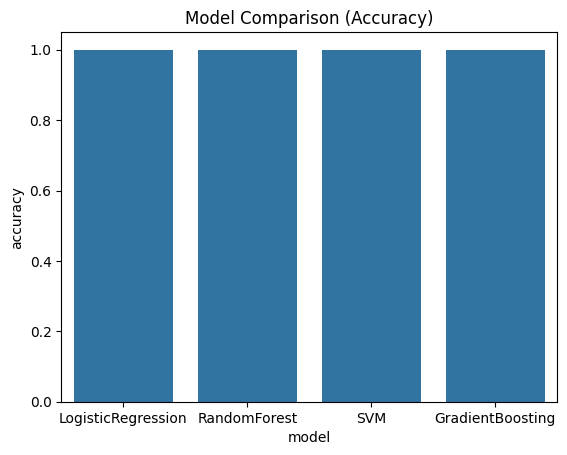

In [31]:
sns.barplot(x='model', y='accuracy', data=results_df.sort_values(by='accuracy', ascending=False))
plt.title('Model Comparison (Accuracy)')
plt.show()

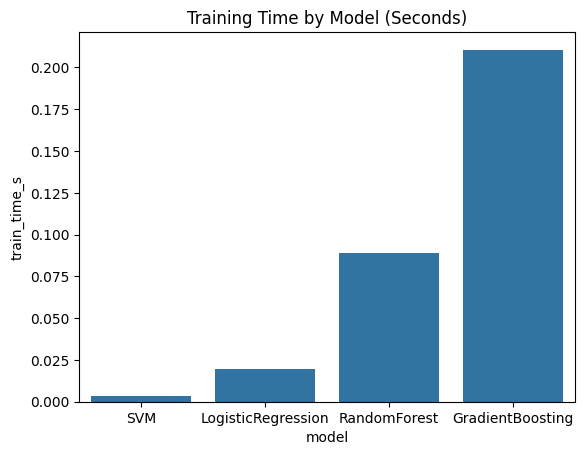

In [32]:
sns.barplot(x='model', y='train_time_s', data=results_df.sort_values(by='train_time_s', ascending=True))
plt.title('Training Time by Model (Seconds)')
plt.show()

## 7. Model Interpretability with SHAP

While predictive accuracy is important, understanding *why* a model makes its predictions is equally valuable — especially for scientific and policy-related data like ecological research.

We use **SHAP (SHapley Additive exPlanations)** to interpret our best-performing model (RandomForest).  

SHAP values quantify each feature's contribution to the model's predictions for individual observations and overall.

In this section, we:
- Compute SHAP values for a representative subset of the data.
- Visualize **global feature importance** to see which variables most strongly influence species classification.
- Optionally inspect **individual prediction explanations** (e.g., using waterfall or force plots).

These insights allow us to connect model predictions back to biological intuition — for instance, how bill length or flipper size help differentiate between penguin species.

In [39]:
import shap
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline


print("Running robust SHAP explanations...")

# 1) Identify the best model
best_model_name = results_df.iloc[0]['model']
print("Best model:", best_model_name)

# 2) Safely retrieve the estimator
model_entry = models.get(best_model_name)
if model_entry is None:
    raise KeyError(f"Model '{best_model_name}' not found in models dictionary.")
estimator = model_entry[0] if isinstance(model_entry, (list, tuple)) else model_entry

# 3) Build a pipeline and fit it on training data
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', estimator)])
pipe.fit(X_train, y_train)
fitted_clf = pipe.named_steps['classifier']
fitted_preproc = pipe.named_steps['preprocessor']

# 4) Prepare a representative sample for SHAP
n_sample = min(200, len(X_train))
X_sample = X_train.sample(n=n_sample, random_state=42)
X_trans_sample = fitted_preproc.transform(X_sample)

# 5) Get feature names after preprocessing
try:
    feature_names = fitted_preproc.get_feature_names_out()
except Exception:
    # fallback if sklearn version does not support get_feature_names_out()
    numeric_names = num_features
    try:
        ohe = fitted_preproc.named_transformers_['cat'].named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(cat_features)
    except Exception:
        ohe_names = [f"{c}_{i}" for c in cat_features for i in range(1)]
    feature_names = list(numeric_names) + list(ohe_names)

X_trans_sample_df = pd.DataFrame(X_trans_sample, columns=feature_names)

# 6) Create a predict_proba wrapper for SHAP
def predict_proba_wrapper(X_in):
    if isinstance(X_in, pd.DataFrame):
        arr = X_in.values
    else:
        arr = np.asarray(X_in)
    return fitted_clf.predict_proba(arr)

# 7) Create SHAP explainer with the sample as background
explainer = shap.Explainer(
    predict_proba_wrapper,
    X_trans_sample_df,
    output_names=[str(c) for c in fitted_clf.classes_]
)

# 8) Compute SHAP values on the same sample
shap_exp = explainer(X_trans_sample_df)

# 9) Generate per-class summary plots
if isinstance(shap_exp, list):
    # Multiclass: list of Explanation objects (one per class)
    for i, class_exp in enumerate(shap_exp):
        class_name = fitted_clf.classes_[i]
        print(f"\nSHAP summary for class '{class_name}'")
        shap.summary_plot(class_exp, X_trans_sample_df, show=True)
else:
    # Binary or regression
    print("\nSingle-output model detected (binary/regression).")
    shap.summary_plot(shap_exp, X_trans_sample_df, show=True)

ModuleNotFoundError: No module named 'shap'

## 8. Conclusion

We've completed a full end-to-end machine learning workflow:
- Loaded and explored the Palmer Penguins dataset  
- Cleaned and preprocessed the data  
- Trained and tuned multiple classifiers  
- Interpreted the final model using SHAP  

The analysis highlights how modern ML tools like LightGBM and SHAP can provide both high accuracy and transparent interpretability — helping us not only predict penguin species but also understand the traits that distinguish them.